## Sentiment Data Collection and PreProcessing

In [ ]:
# This is unable to run in VS Code due to my GPU not being able to handle it, so I run it in colab and bring the files into this directory.

import feedparser
from datetime import datetime, timedelta
from urllib.parse import quote
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#change when running different stocks
QUERY = "Apple stock"         
FILENAME_PREFIX = "AAPL_sentiment"  # for output CSVs
DATE_RANGE_DAYS = 730          # length of lookback
ARTICLES_PER_DAY = 20         # max articles per day to fetch
MAX_WORKERS = 10               # threads for parallel processing

progress_lock = threading.Lock()
completed_days = 0

analyzer = SentimentIntensityAnalyzer()

# Getting news
def fetch_news_by_date(query, target_date, num_articles=10):
    date_str = target_date.strftime('%Y-%m-%d')
    next_day = (target_date + timedelta(days=1)).strftime('%Y-%m-%d')

    # Useing Google RSS
    date_query = f"{query} after:{date_str} before:{next_day}"

    try:
        rss_url = f"https://news.google.com/rss/search?q={quote(date_query)}"
        feed = feedparser.parse(rss_url)
        news_items = feed.entries[:num_articles]

        articles = []
        for item in news_items:
            title = item.title
            link = item.link
            published = getattr(item, "published", None)

            try:
                pub_date = datetime.strptime(published, '%a, %d %b %Y %H:%M:%S %Z')
            except Exception:
                pub_date = target_date

            articles.append({
                "title": title,
                "link": link,
                "published": published,
                "pub_date": pub_date,
                "date": date_str
            })

        return articles
    except Exception as e:
        print(f"Error fetching articles for {date_str}: {e}")
        return []

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    polarity = scores['compound']

    if polarity > 0.3:
        sentiment = 'Positive'
    elif polarity > 0.05:
        sentiment = 'Slightly Positive'
    elif polarity < -0.3:
        sentiment = 'Negative'
    elif polarity < -0.05:
        sentiment = 'Slightly Negative'
    else:
        if polarity >= 0:
            sentiment = 'Slightly Positive'
        else:
            sentiment = 'Slightly Negative'

    return polarity, sentiment

# daily sentiment calculation
def calculate_daily_sentiment_score(articles):
    if not articles:
        return 0, 0

    sentiment_weights = {
        'Positive': 2,
        'Slightly Positive': 1,
        'Slightly Negative': -1,
        'Negative': -2
    }

    total_score = 0
    total_polarity = 0
    count = 0

    for article in articles:
        sentiment = article.get('sentiment')
        polarity = article.get('polarity', 0)

        if sentiment:
            total_score += sentiment_weights[sentiment]
            total_polarity += polarity
            count += 1

    if count == 0:
        return 0, 0

    max_possible_score = count * 2
    min_possible_score = count * -2

    if total_score >= 0:
        normalized_score = (total_score / max_possible_score) * 100 if max_possible_score > 0 else 0
    else:
        normalized_score = (total_score / abs(min_possible_score)) * 100 if min_possible_score < 0 else 0

    avg_polarity = total_polarity / count

    return normalized_score, avg_polarity

def process_single_day(target_date, query):
    global completed_days

    date_str = target_date.strftime('%Y-%m-%d')

    articles = fetch_news_by_date(query, target_date, num_articles=ARTICLES_PER_DAY)

    for article in articles:
        polarity, sentiment = analyze_sentiment(article['title'])
        article['polarity'] = polarity
        article['sentiment'] = sentiment

    with progress_lock:
        completed_days += 1

    return date_str, articles

def summarize_sentiments(articles):
    summary = {
        "Positive": 0,
        "Slightly Positive": 0,
        "Negative": 0,
        "Slightly Negative": 0
    }

    for article in articles:
        sentiment = article.get('sentiment')
        if sentiment:
            summary[sentiment] += 1

    total = len(articles)
    print("\nOverall Sentiment Summary")
    print(f"Total articles analyzed: {total}")
    for sentiment, count in summary.items():
        percent = (count / total) * 100 if total > 0 else 0
        print(f"{sentiment}: {count} ({percent:.2f}%)")

    return summary

def save_to_csv(all_articles, daily_summaries, filename_prefix):
    """
    Save:
      1) All articles with sentiment
      2) Daily summarized sentiment scores
    """
    # All articles
    articles_df = pd.DataFrame(all_articles)
    articles_filename = f"{filename_prefix}_articles.csv"
    articles_df.to_csv(articles_filename, index=False)
    print(f"\n✓ Saved all articles to: {articles_filename}")

    # Daily summaries
    daily_data = []
    for date, summary in sorted(daily_summaries.items()):
        total = summary['total']
        pos = summary['Positive']
        s_pos = summary['Slightly Positive']
        s_neg = summary['Slightly Negative']
        neg = summary['Negative']

        daily_data.append({
            'date': date,
            'sentiment_score': summary['sentiment_score'],    # -100 to +100
            'avg_polarity': summary['avg_polarity'],          # -1 to +1
            'total_articles': total,
            'positive': pos,
            'slightly_positive': s_pos,
            'slightly_negative': s_neg,
            'negative': neg,
            'positive_pct': (pos / total * 100) if total > 0 else 0,
            'slightly_positive_pct': (s_pos / total * 100) if total > 0 else 0,
            'slightly_negative_pct': (s_neg / total * 100) if total > 0 else 0,
            'negative_pct': (neg / total * 100) if total > 0 else 0,
            'bullish_pct': ((pos + s_pos) / total * 100) if total > 0 else 0,
            'bearish_pct': ((neg + s_neg) / total * 100) if total > 0 else 0
        })

    daily_df = pd.DataFrame(daily_data)
    daily_filename = f"{filename_prefix}_daily_summary.csv"
    daily_df.to_csv(daily_filename, index=False)

    return articles_filename, daily_filename

def main():
    global completed_days
    completed_days = 0

    end_date = datetime.now()
    start_date = end_date - timedelta(days=DATE_RANGE_DAYS)

    print(f"Fetching up to {ARTICLES_PER_DAY} articles per day for:")
    print(f"  Query: {QUERY}")
    print(f"  Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}\n")

    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += timedelta(days=1)

    total_days = len(date_list)
    print(f"Total days to process: {total_days}\n")

    all_articles = []
    articles_by_date = {}

    start_time = time.time()

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(process_single_day, date, QUERY): date
            for date in date_list
        }

        for future in as_completed(futures):
            date_str, daily_articles = future.result()
            articles_by_date[date_str] = daily_articles
            all_articles.extend(daily_articles)

            if completed_days % 10 == 0 and completed_days > 0:
                elapsed = time.time() - start_time
                avg_time_per_day = elapsed / completed_days
                remaining_days = total_days - completed_days
                est_remaining = avg_time_per_day * remaining_days

                print(
                    f"Progress: {completed_days}/{total_days} days "
                    f"({completed_days/total_days*100:.1f}%) - "
                    f"Est. remaining: {est_remaining/60:.1f} minutes"
                )

    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time/60:.2f} minutes")
    print(f"Total articles collected: {len(all_articles)}")

    summarize_sentiments(all_articles)

    # Daily summaries with scores
    print("\nCalculating daily summaries with sentiment scores ---")
    daily_summaries = {}
    for date, articles in articles_by_date.items():
        summary = {
            "Positive": 0,
            "Slightly Positive": 0,
            "Negative": 0,
            "Slightly Negative": 0,
            "total": len(articles)
        }

        for article in articles:
            sentiment = article.get('sentiment')
            if sentiment:
                summary[sentiment] += 1

        sentiment_score, avg_polarity = calculate_daily_sentiment_score(articles)
        summary['sentiment_score'] = sentiment_score
        summary['avg_polarity'] = avg_polarity

        daily_summaries[date] = summary

    output_dir = os.path.join("..", "Input_Data")
    os.makedirs(output_dir, exist_ok=True)

    print("\nSaving results to:", output_dir)

    articles_file, daily_file = save_to_csv(all_articles, daily_summaries, os.path.join(output_dir, FILENAME_PREFIX))


if __name__ == "__main__":
    main()

## Technical Data Integration

In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf

# Make sure these match the stock in the first cell
STOCK_TICKER = "AAPL"
DATA_DIR = os.path.join("..", "Input_Data")
SENTIMENT_CSV = "AAPL_sentiment_daily_summary.csv" # change this is running for different stock

sentiment_path = os.path.join(DATA_DIR, SENTIMENT_CSV)

sent_df = pd.read_csv(sentiment_path)


sent_df['date'] = pd.to_datetime(sent_df['date'])
sent_df = sent_df.sort_values('date')

start_date = sent_df['date'].min().normalize()
end_date   = sent_df['date'].max().normalize()

print(f"Using price data for {STOCK_TICKER} from {start_date.date()} to {end_date.date()}")

# Getting stock data for same period as above
stock = yf.download(
    STOCK_TICKER,
    start=start_date,
    end=end_date + pd.Timedelta(days=1),  # including last day
    interval="1d"
)

# To stop from breaking
if stock.empty:
    raise ValueError(f"No data for {STOCK_TICKER} - better luck next time")

if isinstance(stock.columns, pd.MultiIndex):
    stock.columns = stock.columns.droplevel(1)

stock.reset_index(inplace=True)  # 'Date' column

# moving averages 
stock["MA20"] = stock["Close"].rolling(window=20, min_periods=1).mean()
stock["MA50"] = stock["Close"].rolling(window=50, min_periods=1).mean()


stock = stock.reset_index(drop=True).copy()
sent_df = sent_df.reset_index(drop=True).copy()

# Make sure the date columns are proper datetime (and date-only)
stock['date'] = pd.to_datetime(stock['Date']).dt.normalize()
sent_df['date'] = pd.to_datetime(sent_df['date']).dt.normalize()

# merging on date
merged = stock.merge(
    sent_df,
    on='date',
    how='inner'   # inner so only dates that exist in both
)

print("Stock columns:", stock.columns.tolist())
print("Sentiment columns:", sent_df.columns.tolist())
print(f"Merged dataset shape (for modeling later): {merged.shape}")


fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.7, 0.3],
    subplot_titles=(
        f"{STOCK_TICKER} Candlestick with Moving Averages",
        "Daily Volume"
    )
)

# Candlestick
fig.add_trace(
    go.Candlestick(
        x=stock["Date"],
        open=stock["Open"],
        high=stock["High"],
        low=stock["Low"],
        close=stock["Close"],
        name=STOCK_TICKER
    ),
    row=1, col=1
)

# 20-day MA
fig.add_trace(
    go.Scatter(
        x=stock["Date"],
        y=stock["MA20"],
        mode="lines",
        name="MA 20",
        line=dict(width=1.5)
    ),
    row=1, col=1
)

# 50-day MA
fig.add_trace(
    go.Scatter(
        x=stock["Date"],
        y=stock["MA50"],
        mode="lines",
        name="MA 50",
        line=dict(width=1.5)
    ),
    row=1, col=1
)

# bar chart
fig.add_trace(
    go.Bar(
        x=stock["Date"],
        y=stock["Volume"],
        name="Volume",
        opacity=0.4
    ),
    row=2, col=1
)

fig.update_layout(
    title=f"{STOCK_TICKER} Technical Chart – Same Period as Sentiment Data",
    xaxis2_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    height=800
)

fig.show()

fig.update_layout(
    yaxis2=dict(
        title="Sentiment Score",
        overlaying="y",
        side="right",
        range=[-100, 100],
        showgrid=False
    )
)
fig.add_trace(
    go.Scatter(
        x=merged["date"],
        y=merged["sentiment_score"],
        mode="lines",
        name="Sentiment Score (0–100)",
        line=dict(color="purple", width=2),
        yaxis="y2"
    )
)




C:\Users\tylhug\AppData\Local\Temp\ipykernel_31444\3017345287.py:26: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Using price data for AAPL from 2023-03-22 to 2025-12-16
Stock columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'MA20', 'MA50', 'date']
Sentiment columns: ['date', 'sentiment_score', 'avg_polarity', 'total_articles', 'positive', 'slightly_positive', 'slightly_negative', 'negative', 'positive_pct', 'slightly_positive_pct', 'slightly_negative_pct', 'negative_pct', 'bullish_pct', 'bearish_pct']
Merged dataset shape (for modeling later): (688, 22)


## Building the complete dataset with both sentiment and technical

In [7]:
sent_df['date'] = pd.to_datetime(sent_df['date']).dt.normalize()

print("Sentiment DataFrame Columns:\n", sent_df.columns.tolist(), "\n")
display(sent_df.head(10))

# Normalize and merge
stock['date'] = pd.to_datetime(stock['Date']).dt.normalize()
merged_df = pd.merge(stock, sent_df, on='date', how='inner')

# Daily % return and shifted targets
merged_df['daily_return'] = merged_df['Close'].pct_change() * 100
merged_df['next_day_return'] = merged_df['daily_return'].shift(-1)
merged_df['next_day_up'] = (merged_df['next_day_return'] > 0).astype(int)

merged_df.dropna(inplace=True)

# Reorder columns
cols = [
    'date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'daily_return',
    'next_day_return', 'next_day_up',
    'sentiment_score', 'avg_polarity', 'total_articles',
    'positive', 'slightly_positive', 'slightly_negative', 'negative',
    'positive_pct', 'slightly_positive_pct', 'slightly_negative_pct',
    'negative_pct', 'bullish_pct', 'bearish_pct'
]
merged_df = merged_df[cols]

print(f"Merged DataFrame shape: {merged_df.shape}")
display(merged_df.head(10))



Sentiment DataFrame Columns:
 ['date', 'sentiment_score', 'avg_polarity', 'total_articles', 'positive', 'slightly_positive', 'slightly_negative', 'negative', 'positive_pct', 'slightly_positive_pct', 'slightly_negative_pct', 'negative_pct', 'bullish_pct', 'bearish_pct'] 



,date,sentiment_score,avg_polarity,total_articles,positive,slightly_positive,slightly_negative,negative,positive_pct,slightly_positive_pct,slightly_negative_pct,negative_pct,bullish_pct,bearish_pct
0,2023-03-22,30.000000,0.015700,10,2,6,0,2,20.000000,60.000000,0.000000,20.000000,80.000000,20.000000
1,2023-03-23,27.777778,-0.013578,9,2,5,0,2,22.222222,55.555556,0.000000,22.222222,77.777778,22.222222
2,2023-03-24,55.555556,0.188189,9,3,5,1,0,33.333333,55.555556,11.111111,0.000000,88.888889,11.111111
3,2023-03-25,58.333333,0.245133,6,3,2,1,0,50.000000,33.333333,16.666667,0.000000,83.333333,16.666667
4,2023-03-26,45.000000,0.060160,10,2,7,0,1,20.000000,70.000000,0.000000,10.000000,90.000000,10.000000
5,2023-03-27,15.000000,0.047750,10,2,4,3,1,20.000000,40.000000,30.000000,10.000000,60.000000,40.000000
6,2023-03-28,15.000000,0.025550,10,2,4,3,1,20.000000,40.000000,30.000000,10.000000,60.000000,40.000000
7,2023-03-29,30.000000,0.115110,10,4,3,1,2,40.000000,30.000000,10.000000,20.000000,70.000000,30.000000
8,2023-03-30,22.222222,0.060056,9,4,2,0,3,44.444444,22.222222,0.000000,33.333333,66.666667,33.333333
9,2023-03-31,35.000000,0.003870,10,2,6,1,1,20.000000,60.000000,10.000000,10.000000,80.000000,20.000000


Merged DataFrame shape: (686, 24)


,date,Open,High,Low,Close,Volume,MA20,MA50,daily_return,next_day_return,...,positive,slightly_positive,slightly_negative,negative,positive_pct,slightly_positive_pct,slightly_negative_pct,negative_pct,bullish_pct,bearish_pct
1,2023-03-23,156.708367,159.392035,155.573719,156.807022,67622100,156.264374,156.264374,0.696946,0.830564,...,2,5,0,2,22.222222,55.555556,0.000000,22.222222,77.777778,22.222222
2,2023-03-24,156.737974,158.198200,155.741470,158.109406,59196500,156.879384,156.879384,0.830564,-1.229345,...,3,5,1,0,33.333333,55.555556,11.111111,0.000000,88.888889,11.111111
3,2023-03-27,157.803525,158.622439,155.761168,156.165695,52390300,156.700962,156.700962,-1.229345,-0.398037,...,2,4,3,1,20.000000,40.000000,30.000000,10.000000,60.000000,40.000000
4,2023-03-28,155.859831,156.372889,153.896408,155.544098,45992200,156.469589,156.469589,-0.398037,1.979088,...,2,4,3,1,20.000000,40.000000,30.000000,10.000000,60.000000,40.000000
5,2023-03-29,157.241144,158.898710,157.221422,158.622452,51305700,156.828400,156.828400,1.979088,0.988997,...,4,3,1,2,40.000000,30.000000,10.000000,20.000000,70.000000,30.000000
6,2023-03-30,159.372308,160.299754,159.115787,160.191223,49501700,157.308803,157.308803,0.988997,1.564407,...,4,2,0,3,44.444444,22.222222,0.000000,33.333333,66.666667,33.333333
7,2023-03-31,160.270135,162.795936,159.747216,162.697266,68749800,157.982361,157.982361,1.564407,0.770164,...,2,6,1,1,20.000000,60.000000,10.000000,10.000000,80.000000,20.000000
8,2023-04-03,162.075688,164.068694,162.026353,163.950302,56976200,158.645465,158.645465,0.770164,-0.324953,...,2,5,1,2,20.000000,50.000000,10.000000,20.000000,70.000000,30.000000
9,2023-04-04,164.374586,164.611370,162.904483,163.417542,46278300,159.122673,159.122673,-0.324953,-1.129048,...,4,4,0,1,44.444444,44.444444,0.000000,11.111111,88.888889,11.111111
10,2023-04-05,162.539399,162.845256,159.638669,161.572479,51511700,159.345383,159.345383,-1.129048,0.549608,...,2,6,0,2,20.000000,60.000000,0.000000,20.000000,80.000000,20.000000


## Model ready dataset

In [8]:
merged_df = merged_df.sort_values('date').reset_index(drop=True)

# Daily returns
merged_df['return_1d'] = merged_df['Close'].pct_change()
merged_df['return_5d'] = merged_df['Close'].pct_change(5)

# RSI (Relative Strength Index 14-day)
window = 14
delta = merged_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / (loss + 1e-9)
merged_df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD (12,26) and Signal (9)
ema12 = merged_df['Close'].ewm(span=12, adjust=False).mean()
ema26 = merged_df['Close'].ewm(span=26, adjust=False).mean()
merged_df['MACD'] = ema12 - ema26
merged_df['MACD_Signal'] = merged_df['MACD'].ewm(span=9, adjust=False).mean()
merged_df['MACD_Hist'] = merged_df['MACD'] - merged_df['MACD_Signal']

# Bollinger Bands (20-day)
rolling_mean = merged_df['Close'].rolling(20).mean()
rolling_std = merged_df['Close'].rolling(20).std()
merged_df['Bollinger_Width'] = (rolling_std * 2) / rolling_mean

# Rolling Volatility (10-day, 20-day)
merged_df['Volatility_10'] = merged_df['daily_return'].rolling(10).std()
merged_df['Volatility_20'] = merged_df['daily_return'].rolling(20).std()

# MA cross (1 if MA20 > MA50)
merged_df['MA_Cross'] = (merged_df['MA20'] > merged_df['MA50']).astype(int)

# Sentiment change and rolling trend
merged_df['sentiment_change'] = merged_df['sentiment_score'].diff()
merged_df['sentiment_rolling_mean_3'] = merged_df['sentiment_score'].rolling(3).mean()

# Sentiment z-score (relative to 20-day window)
merged_df['sentiment_z'] = (
    (merged_df['sentiment_score'] - merged_df['sentiment_score'].rolling(20).mean()) /
    (merged_df['sentiment_score'].rolling(20).std() + 1e-9)
)

# Pos/Neg ratio
merged_df['pos_neg_ratio'] = (merged_df['positive'] + 1) / (merged_df['negative'] + 1)

# Bull/Bear ratio
merged_df['bull_bear_ratio'] = (merged_df['bullish_pct'] + 1e-9) / (merged_df['bearish_pct'] + 1e-9)

merged_df.fillna(method='bfill', inplace=True)
merged_df.fillna(method='ffill', inplace=True)

print(f"New columns added: {len(merged_df.columns)} total")
display(merged_df.tail(10))

New columns added: 39 total


C:\Users\tylhug\AppData\Local\Temp\ipykernel_31444\2502129357.py:50: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\tylhug\AppData\Local\Temp\ipykernel_31444\2502129357.py:51: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,Open,High,Low,Close,Volume,MA20,MA50,daily_return,next_day_return,...,MACD_Hist,Bollinger_Width,Volatility_10,Volatility_20,MA_Cross,sentiment_change,sentiment_rolling_mean_3,sentiment_z,pos_neg_ratio,bull_bear_ratio
676,2025-12-02,283.000000,287.399994,282.630005,286.190002,53669500,273.033279,263.822832,1.091486,-0.712816,...,0.853803,0.039696,0.863812,0.984034,1,20.0,40.833333,1.590827,3.50,9.000000e+00
677,2025-12-03,286.200012,288.619995,283.299988,284.149994,43538700,273.751855,264.422160,-0.712816,-1.214141,...,0.857989,0.043080,0.950826,1.010507,1,2.5,46.666667,1.585374,5.00,1.900000e+01
678,2025-12-04,284.100006,284.730011,278.589996,280.700012,43989100,274.292937,264.994847,-1.214141,-0.684009,...,0.553530,0.043878,1.113917,1.062721,1,-20.0,47.500000,-0.031151,1.50,4.000000e+00
679,2025-12-05,280.540009,281.140015,278.049988,278.779999,47265800,274.756500,265.438023,-0.684009,-0.319242,...,0.167956,0.043579,1.092102,1.078825,1,-5.0,40.000000,-0.527840,1.00,4.000000e+00
680,2025-12-08,278.130005,279.670013,276.149994,277.890015,38211800,275.240501,265.891571,-0.319242,-0.255505,...,-0.182896,0.042280,0.975970,1.074218,1,42.5,45.833333,2.552447,6.50,1.900000e+01
681,2025-12-09,278.160004,280.029999,276.920013,277.179993,32193300,275.628001,266.351499,-0.255505,0.577244,...,-0.481690,0.041124,0.850869,1.076494,1,-40.0,45.000000,-0.377959,1.75,3.000000e+00
682,2025-12-10,277.750000,279.750000,276.440002,278.779999,33038300,275.804501,266.839431,0.577244,-0.269029,...,-0.583674,0.041405,0.861596,0.974040,1,25.0,54.166667,1.342932,4.00,5.666667e+00
683,2025-12-11,279.100006,279.589996,273.809998,278.029999,33248000,276.032501,267.295979,-0.269029,0.089918,...,-0.705596,0.041319,0.866173,0.963050,1,-5.0,47.500000,0.935428,8.00,5.666667e+00
684,2025-12-12,277.899994,279.220001,276.820007,278.279999,39532900,276.299001,267.723959,0.089918,-1.498496,...,-0.768199,0.041083,0.852597,0.960840,1,12.5,58.333333,1.573498,7.00,1.000000e+11
685,2025-12-15,280.149994,280.149994,272.839996,274.109985,50409100,276.384000,268.050757,-1.498496,0.182409,...,-1.070663,0.040717,0.777980,1.024075,1,-45.0,45.833333,-1.262109,2.00,1.857143e+00


## Prediction Targets

In [9]:
merged_df = merged_df.sort_values('date').reset_index(drop=True)


merged_df['future_return_3d'] = merged_df['Close'].pct_change(3).shift(-3)
merged_df['future_return_5d'] = merged_df['Close'].pct_change(5).shift(-5)

# Binary classification labels
merged_df['future_up_3d'] = (merged_df['future_return_3d'] > 0).astype(int)
merged_df['future_up_5d'] = (merged_df['future_return_5d'] > 0).astype(int)

# Drop trailing NaNs 
merged_df = merged_df.dropna(subset=['future_return_3d', 'future_return_5d'])

# Check class balance
print("3-day UP ratio:", merged_df['future_up_3d'].mean().round(3))
print("5-day UP ratio:", merged_df['future_up_5d'].mean().round(3))
print(f"Total samples remaining: {len(merged_df)}")


3-day UP ratio: 0.573
5-day UP ratio: 0.57
Total samples remaining: 681


In [10]:
from sklearn.model_selection import train_test_split

feature_cols = [col for col in merged_df.columns if col not in [
    'Date','date','future_return_3d','future_return_5d','future_up_3d','future_up_5d',
    'next_day_return','next_day_up'
]]
X = merged_df[feature_cols]
y = merged_df['future_up_3d']   # choose 3-day target (can change to 'future_up_5d')

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (476, 36), Val: (102, 36), Test: (103, 36)


## Model Fitting and Validation

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed   = imputer.transform(X_val)
X_test_imputed  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled   = scaler.transform(X_val_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

# Logistic Regression
log_clf = LogisticRegression(max_iter=1000, solver='lbfgs')
log_clf.fit(X_train_scaled, y_train)

y_pred_val_log = log_clf.predict(X_val_scaled)
y_proba_val_log = log_clf.predict_proba(X_val_scaled)[:, 1]

acc_log = accuracy_score(y_val, y_pred_val_log)
f1_log = f1_score(y_val, y_pred_val_log)
auc_log = roc_auc_score(y_val, y_proba_val_log)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_imputed, y_train)

y_pred_val_rf = rf_clf.predict(X_val_imputed)
y_proba_val_rf = rf_clf.predict_proba(X_val_imputed)[:, 1]

acc_rf = accuracy_score(y_val, y_pred_val_rf)
f1_rf = f1_score(y_val, y_pred_val_rf)
auc_rf = roc_auc_score(y_val, y_proba_val_rf)

# XGBoost Classifier
xgb_clf = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb_clf.fit(X_train_imputed, y_train,
            eval_set=[(X_val_imputed, y_val)],
            verbose=False)

y_pred_val_xgb = xgb_clf.predict(X_val_imputed)
y_proba_val_xgb = xgb_clf.predict_proba(X_val_imputed)[:, 1]

acc_xgb = accuracy_score(y_val, y_pred_val_xgb)
f1_xgb = f1_score(y_val, y_pred_val_xgb)
auc_xgb = roc_auc_score(y_val, y_proba_val_xgb)

# Compare validation results
results_clf = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_log, acc_rf, acc_xgb],
    'F1 Score': [f1_log, f1_rf, f1_xgb],
    'ROC AUC': [auc_log, auc_rf, auc_xgb]
}).sort_values('ROC AUC', ascending=False)

print("\n=== Validation Results (3-Day Smoothed Target) ===")
display(results_clf)

# Confusion Matrix + Classification Report for Best Model
best_model = xgb_clf
best_pred = y_pred_val_xgb
cm = confusion_matrix(y_val, best_pred)

print("\nConfusion Matrix (Validation):")
print(cm)

print("\nClassification Report (Validation):")
print(classification_report(y_val, best_pred))

# Evaluate on Test Set
y_pred_test = best_model.predict(X_test_imputed)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTest Set Accuracy (3-Day Target): {test_acc*100:.2f}%")


MODELS_DIR = os.path.join("..", "Models")
os.makedirs(MODELS_DIR, exist_ok=True)

# === Save preprocessing objects ===
joblib.dump(imputer, os.path.join(MODELS_DIR, "imputer.pkl"))
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.pkl"))

# === Save individual models ===
joblib.dump(log_clf, os.path.join(MODELS_DIR, "logistic_regression_model.pkl"))
joblib.dump(rf_clf, os.path.join(MODELS_DIR, "random_forest_model.pkl"))
joblib.dump(xgb_clf, os.path.join(MODELS_DIR, "xgboost_model.pkl"))

# === Save full pipeline for XGBoost (best model) ===
final_pipeline = {
    "model": xgb_clf,
    "imputer": imputer,
    "scaler": scaler,
    "features": X.columns.tolist()
}
joblib.dump(final_pipeline, os.path.join(MODELS_DIR, "final_xgb_pipeline.pkl"))




=== Validation Results (3-Day Smoothed Target) ===


,Model,Accuracy,F1 Score,ROC AUC
2,XGBoost,0.598039,0.696296,0.621914
1,Random Forest,0.588235,0.700000,0.590664
0,Logistic Regression,0.509804,0.615385,0.533951



Confusion Matrix (Validation):
[[14 34]
 [ 7 47]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.67      0.29      0.41        48
           1       0.58      0.87      0.70        54

    accuracy                           0.60       102
   macro avg       0.62      0.58      0.55       102
weighted avg       0.62      0.60      0.56       102


Test Set Accuracy (3-Day Target): 52.43%


['..\\Models\\final_xgb_pipeline.pkl']

In [13]:
# Compute class balance
up_ratio = y_test.mean()
down_ratio = 1 - up_ratio

print(f"Percent of 'Up' (3-Day) periods:   {up_ratio * 100:.2f}%")
print(f"Percent of 'Down' (3-Day) periods: {down_ratio * 100:.2f}%")

# Compute baseline accuracy (always predict majority class)
baseline_accuracy = max(up_ratio, down_ratio)
print(f"\nBaseline accuracy (majority class): {baseline_accuracy * 100:.2f}%")

# Compute your model’s test accuracy for comparison
y_pred_test = xgb_clf.predict(X_test_imputed)
model_accuracy = (y_pred_test == y_test).mean()

print(f"Model accuracy on test set: {model_accuracy * 100:.2f}%")

improvement = (model_accuracy - baseline_accuracy) * 100
print(f"Improvement over baseline: {improvement:.2f} percentage points")

# Binomial test 
n_total = len(y_test)
n_correct = sum(y_pred_test == y_test)
p_null = baseline_accuracy  # expected accuracy under null

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (Test Set):")
print(cm)


Percent of 'Up' (3-Day) periods:   58.25%
Percent of 'Down' (3-Day) periods: 41.75%

Baseline accuracy (majority class): 58.25%
Model accuracy on test set: 52.43%
Improvement over baseline: -5.83 percentage points

Confusion Matrix (Test Set):
[[35  8]
 [41 19]]


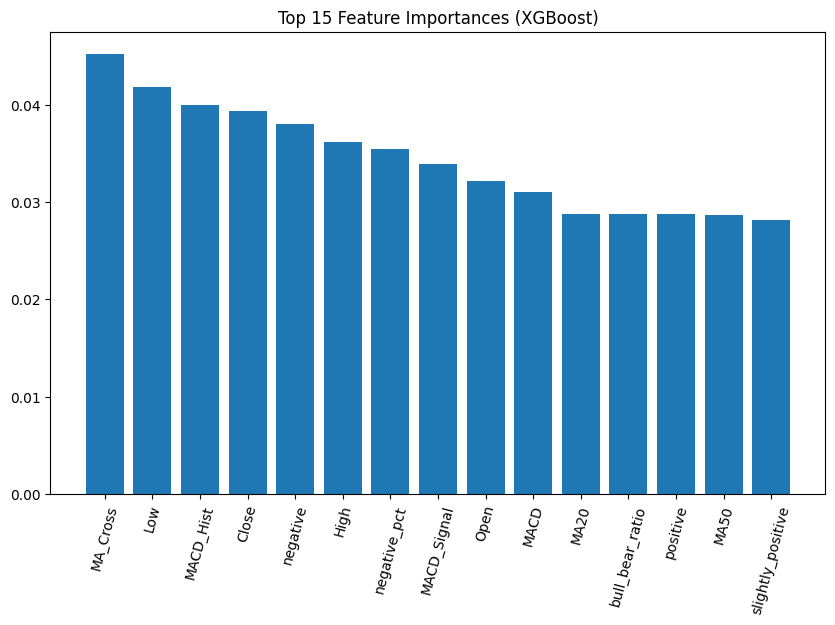

In [21]:
import matplotlib.pyplot as plt

importance = best_model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(15), importance[sorted_idx][:15])
plt.xticks(range(15), np.array(X_train.columns)[sorted_idx][:15], rotation=75)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()


# Prediction Using Excel Template

In [18]:
TEMPLATE_DIR = os.path.join("..", "Template")
MODELS_DIR = os.path.join("..", "Models")

template_path = os.path.join(TEMPLATE_DIR, "prediction_template.xlsx")
pipeline_path = os.path.join(MODELS_DIR, "final_xgb_pipeline.pkl")

# Load model and preprocessing pipeline
if not os.path.exists(pipeline_path):
    raise FileNotFoundError(f"Model pipeline not found: {pipeline_path}")
else:
    print(f"📦 Loading model pipeline from: {pipeline_path}")

pipeline = joblib.load(pipeline_path)
model = pipeline["model"]
imputer = pipeline["imputer"]
scaler = pipeline["scaler"]
features = pipeline["features"]

test_point = pd.read_excel(template_path)

# Validate and reorder columns
missing_cols = set(features) - set(test_point.columns)
if missing_cols:
    raise ValueError(f"Missing columns in Excel file: {missing_cols}")

test_point = test_point[features]

# Apply same preprocessing
test_point_imputed = imputer.transform(test_point)
test_point_scaled = scaler.transform(test_point_imputed)

y_pred_class = model.predict(test_point_imputed)[0]
y_pred_prob = model.predict_proba(test_point_imputed)[0, 1]

direction = "UP" if y_pred_class == 1 else "DOWN"

print("\n=== PREDICTION RESULT ===")
print(f"Predicted 3-Day Market Direction: {direction}")
print(f"Predicted Probability of 'Up': {y_pred_prob:.2%}")
print(f"Excel Source: {template_path}")

📦 Loading model pipeline from: ..\Models\final_xgb_pipeline.pkl

=== PREDICTION RESULT ===
Predicted 3-Day Market Direction: UP
Predicted Probability of 'Up': 98.82%
Excel Source: ..\Template\prediction_template.xlsx
